# MRS etalon line overlap
In this notebook we attempt to derive a wavelength solution for MRS band 1A based on the periodic pattern of the etalon line overlapping in the RAL FTS and the MIRI FM datasets.  

In [1]:
# load python modules
import funcs
import mrsobs

import numpy as np
from matplotlib import pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
# Define paths to data
workDir  = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir   = workDir+'cdp_data/'
lvl2path = workDir+'/FM_data/LVL2/'
d2cMapDir = workDir+'notebooks/distortionMaps/'
MRSWaveCalDir = workDir+'MRSWaveCal/'

# MRS spectral band
bands = ['1A','1B','1C','2A','2B','2C','3A','3B','3C','4A','4B','4C']

# MRS etalons
etalons = ['ET1A','ET1B','ET2A','ET2B']

In [3]:
# load data
wavs_fts,etalon_data_fts,etalon_data_fm = {},{},{}
for i,etalon in enumerate(['ET1A','ET1B']):
    wavs_fts[etalon],etalon_data_fts[etalon],etalon_data_fm[etalon] = {},{},{}
    wvnrs_fts,data  = mrsobs.RAL_FTS_ET_observations(MRSWaveCalDir,etalon=etalon)
    wavelengths = np.flipud(10000./wvnrs_fts)
    
    for band in bands:
        lamblower,lambupper = funcs.mrs_aux(band)[3]
        sel = (wavelengths>lamblower) & (wavelengths<lambupper)
        wavs_fts[etalon][band],etalon_data_fts[etalon][band] = wavelengths[sel],np.flipud(data)[sel]
        
        sci_img,bkg_img  = mrsobs.FM_MTS_800K_BB_extended_source_through_etalon(lvl2path,band,etalon=etalon)
        etalon_data_fm[etalon][band] = sci_img-bkg_img

<IPython.core.display.Javascript object>


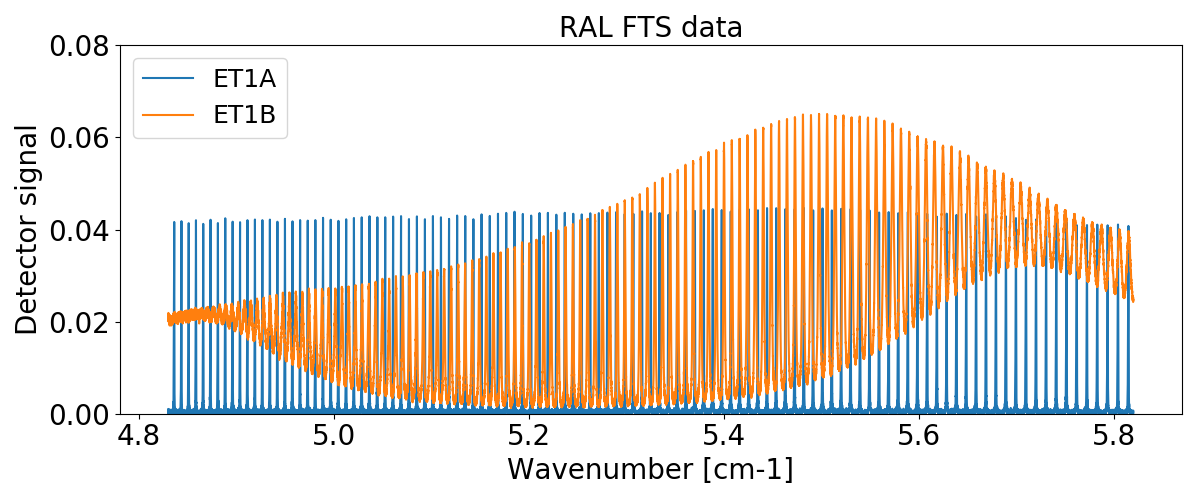

<IPython.core.display.Javascript object>


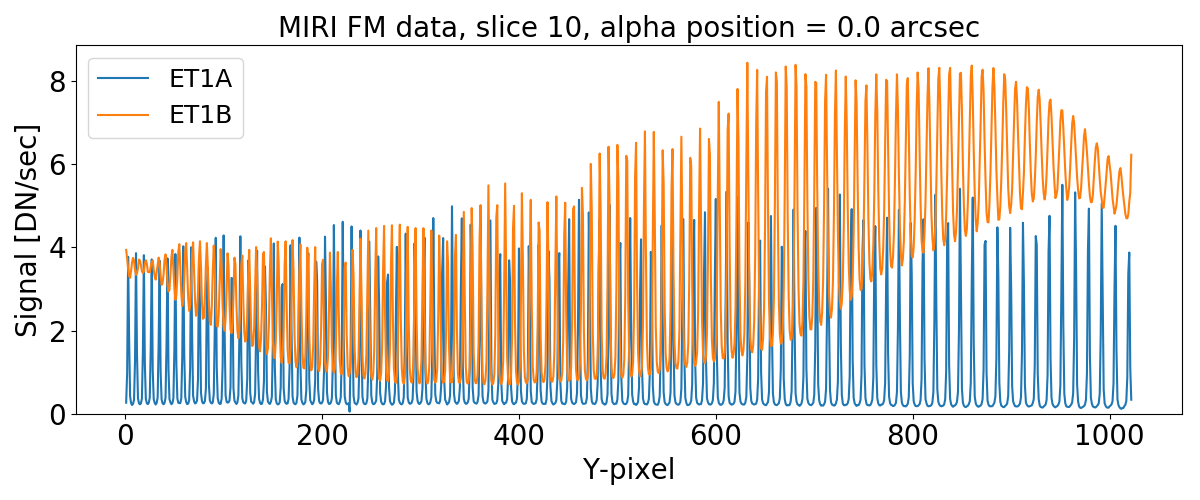

In [4]:
# plot data
band = '1A'

plt.figure(figsize=(12,5))
plt.plot(wavs_fts['ET1A'][band],etalon_data_fts['ET1A'][band],label='ET1A')
plt.plot(wavs_fts['ET1B'][band],etalon_data_fts['ET1B'][band],label='ET1B')
plt.ylim(0.,0.08)
plt.xlabel('Wavenumber [cm-1]')
plt.ylabel('Detector signal')
plt.title('RAL FTS data')
plt.legend(loc='upper left',fontsize=18)
plt.tight_layout()

d2cMaps = funcs.load_obj('d2cMaps_band{}_tr80pc'.format(band),path=d2cMapDir)
islice,alpha_pos = d2cMaps['nslices']/2,0.
ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=islice,alpha_pos=alpha_pos)

plt.figure(figsize=(12,5))
plt.plot(etalon_data_fm['ET1A'][band][ypos,xpos],label='ET1A')
plt.plot(etalon_data_fm['ET1B'][band][ypos,xpos]/2.,label='ET1B')
plt.ylim(0)
plt.xlabel('Y-pixel')
plt.ylabel('Signal [DN/sec]')
plt.title('MIRI FM data, slice {}, alpha position = {} arcsec'.format(islice,alpha_pos))
plt.legend(loc='upper left',fontsize=18)
plt.tight_layout()

<IPython.core.display.Javascript object>


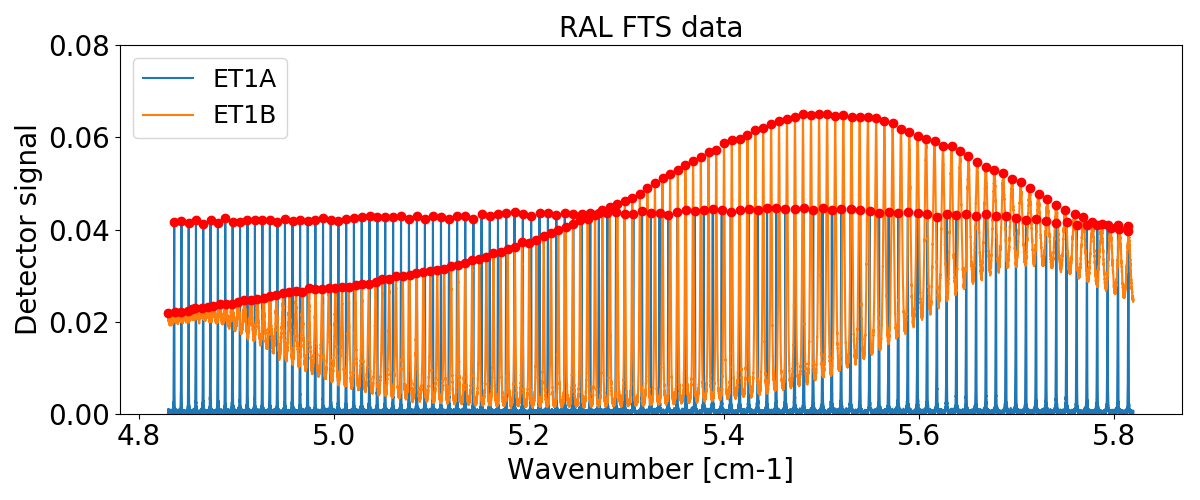

<IPython.core.display.Javascript object>


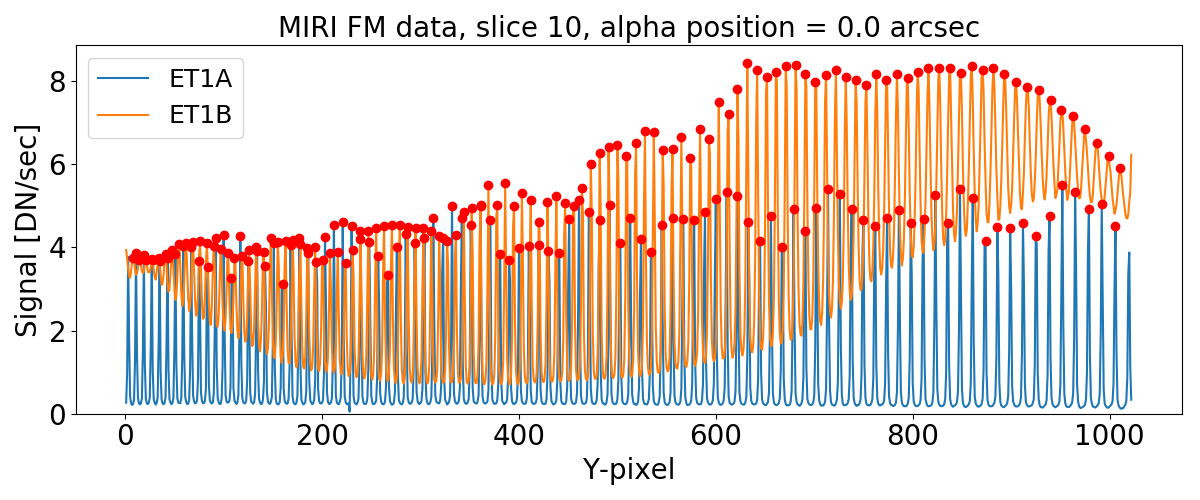

In [5]:
# determine peaks
etalon1A_data_fts_peaks = funcs.find_peaks(etalon_data_fts['ET1A'][band], thres=0.3, min_dist=20)
etalon1B_data_fts_peaks = funcs.find_peaks(etalon_data_fts['ET1B'][band], thres=0.3, min_dist=200)

etalon1A_data_fm_peaks = funcs.find_peaks(etalon_data_fm['ET1A'][band][ypos,xpos], thres=0.3, min_dist=5)
etalon1B_data_fm_peaks = funcs.find_peaks(etalon_data_fm['ET1B'][band][ypos,xpos], thres=0.3, min_dist=5)

#-- remove peaks too close to edges
etalon1A_data_fm_peaks = etalon1A_data_fm_peaks[(etalon1A_data_fm_peaks>4) & (etalon1A_data_fm_peaks<1020)]
etalon1B_data_fm_peaks = etalon1B_data_fm_peaks[(etalon1B_data_fm_peaks>4) & (etalon1B_data_fm_peaks<1020)]

plt.figure(figsize=(12,5))
plt.plot(wavs_fts['ET1A'][band],etalon_data_fts['ET1A'][band],label='ET1A')
plt.plot(wavs_fts['ET1B'][band],etalon_data_fts['ET1B'][band],label='ET1B')
plt.plot(wavs_fts['ET1A'][band][etalon1A_data_fts_peaks],etalon_data_fts['ET1A'][band][etalon1A_data_fts_peaks],'ro')
plt.plot(wavs_fts['ET1B'][band][etalon1B_data_fts_peaks],etalon_data_fts['ET1B'][band][etalon1B_data_fts_peaks],'ro')
plt.ylim(0.,0.08)
plt.xlabel('Wavenumber [cm-1]')
plt.ylabel('Detector signal')
plt.title('RAL FTS data')
plt.legend(loc='upper left',fontsize=18)
plt.tight_layout()

plt.figure(figsize=(12,5))
plt.plot(etalon_data_fm['ET1A'][band][ypos,xpos],label='ET1A')
plt.plot(etalon_data_fm['ET1B'][band][ypos,xpos]/2.,label='ET1B')
plt.plot(etalon1A_data_fm_peaks,etalon_data_fm['ET1A'][band][ypos,xpos][etalon1A_data_fm_peaks],'ro')
plt.plot(etalon1B_data_fm_peaks,etalon_data_fm['ET1B'][band][ypos,xpos][etalon1B_data_fm_peaks]/2.,'ro')
plt.ylim(0)
plt.xlabel('Y-pixel')
plt.ylabel('Signal [DN/sec]')
plt.title('MIRI FM data, slice {}, alpha position = {} arcsec'.format(islice,alpha_pos))
plt.legend(loc='upper left',fontsize=18)
plt.tight_layout()

In [6]:
# Traces for each isoalpha are identified based on the following criteria:
if band[0] in ['1','2']:
    alpha_high,alpha_low,thres_e1a,min_dist_e1a,sigma0_e1a,thres_e1b,min_dist_e1b,sigma0_e1b = funcs.etalon_line_params(band)
elif band[0] in ['4']:
    alpha_high,alpha_low,thres_e2b,min_dist_e2b,sigma0_e2b = funcs.etalon_line_params(band)

In [7]:
# Choose data regions
if band[0] in ['1','2']:
    #--FM data
    etalon1A_fm_data_noNaN = etalon_data_fm['ET1A'][band][ypos,xpos]
    etalon1B_fm_data_noNaN = etalon_data_fm['ET1B'][band][ypos,xpos]

    # Remove NaNs
    etalon1A_fm_data_noNaN[np.isnan(etalon1A_fm_data_noNaN)] = 0.
    etalon1B_fm_data_noNaN[np.isnan(etalon1B_fm_data_noNaN)] = 0.

    print("Number of identified etalon lines :     [alpha = "+str(alpha_pos)+"]\n FM ET_1A etalon data: {} lines \n FM ET_1B etalon data: {} lines".format(len(etalon1A_data_fm_peaks),len(etalon1B_data_fm_peaks)))

elif band[0] in ['4']:
    #--FM data
    etalon2B_fm_data = etalon2B_img[ypos,xpos]

    # Determine etalon peaks
    #--FM Etalon_2B data
    etalon2B_fm_data[np.isnan(etalon2B_fm_data)] = -1
    FMetalon2B_peaks = funcs.find_peaks(etalon2B_fm_data,thres=thres_e2b,min_dist=min_dist_e2b)
    FMetalon2B_peaks = FMetalon2B_peaks[(FMetalon2B_peaks>4) & (FMetalon2B_peaks<1020) & (etalon2B_fm_data[FMetalon2B_peaks]>0)]
    etalon2B_fm_data[(etalon2B_fm_data == -1)] = np.nan
    etalon2B_fm_data_noNaN = etalon2B_fm_data.copy()
    etalon2B_fm_data_noNaN[np.isnan(etalon2B_fm_data)] = 0.
    
    print("Number of identified etalon lines :     [alpha = "+str(alpha_pos)+"]\n FM ET_2B etalon data: {} lines".format(len(etalon2B_data_fm_peaks)))

Number of identified etalon lines :     [alpha = 0.0]
 FM ET_1A etalon data: 97 lines 
 FM ET_1B etalon data: 113 lines


<IPython.core.display.Javascript object>


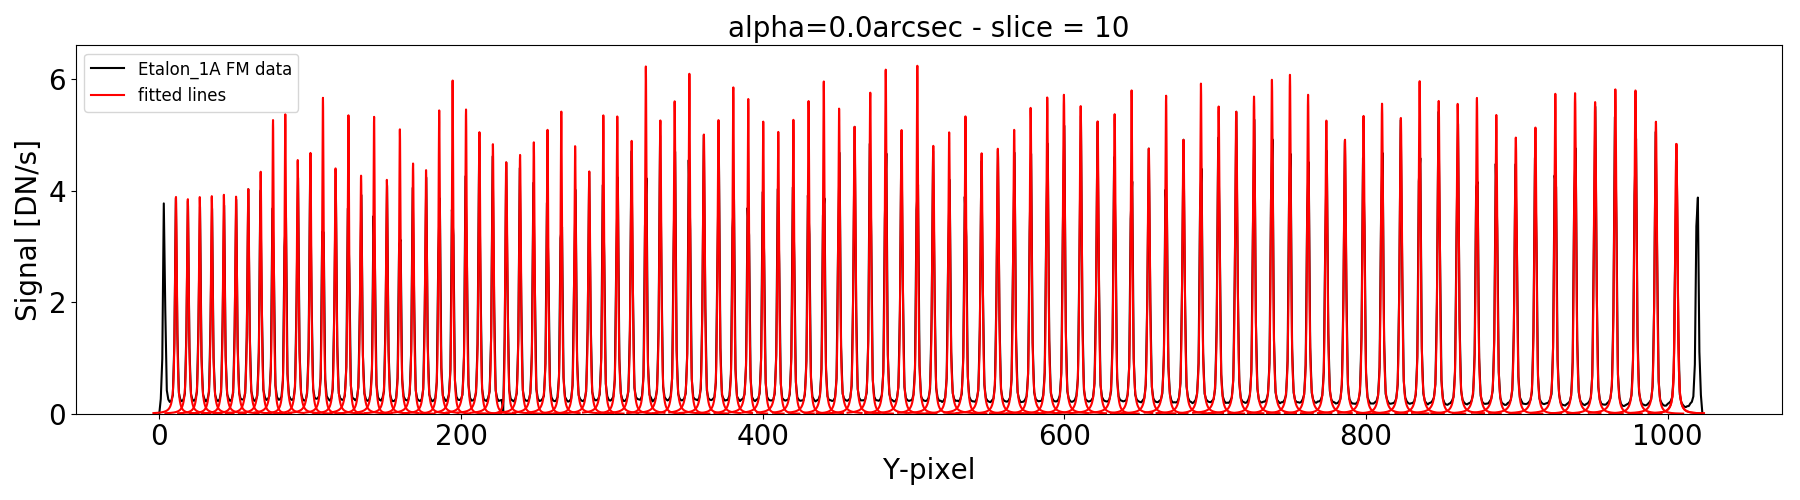

In [8]:
if band[0] in ['1','2']:
    FMetalon1A_fitparams,FMetalon1A_fiterrors,fitting_flag,range_ini,range_fin = funcs.fit_etalon_lines(np.arange(len(ypos)),etalon1A_fm_data_noNaN,etalon1A_data_fm_peaks,fit_func='skewed_voight',sigma0=sigma0_e1a,f0=0.5,a0=0.1)
    
    fm_linecenter_ET1A = funcs.get_linecenter(FMetalon1A_fitparams,fitting_flag)
    
    # Plot the fits
    plt.figure(figsize=(18,5))
    plt.plot(etalon1A_fm_data_noNaN,'k',label='Etalon_1A FM data')
    funcs.plot_etalon_fit(FMetalon1A_fitparams,fitting_flag)
    plt.ylim(0,1.2*max(etalon1A_fm_data_noNaN))
    plt.xlabel('Y-pixel',fontsize=20)
    plt.ylabel('Signal [DN/s]',fontsize=20)
    plt.title("alpha={}arcsec - slice = {}".format(str(alpha_pos),islice))
    plt.tick_params(axis='both',labelsize=20)
    plt.legend(loc='upper left',fontsize=12)
    plt.tight_layout()

<IPython.core.display.Javascript object>


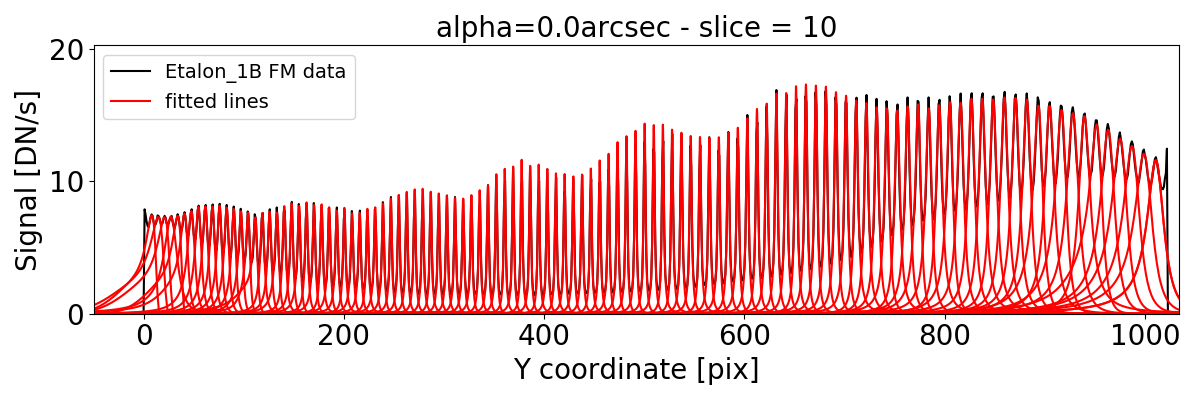

In [9]:
if band[0] in ['1','2']:
    FMetalon1B_fitparams,FMetalon1B_fiterrors,fitting_flag,range_ini,range_fin = funcs.fit_etalon_lines(np.arange(len(ypos)),etalon1B_fm_data_noNaN,etalon1B_data_fm_peaks,fit_func='skewed_voight',sigma0=sigma0_e1b,f0=0.5,a0=0.1)

    fm_linecenter_ET1B = funcs.get_linecenter(FMetalon1B_fitparams,fitting_flag)
    
    plt.figure(figsize=(12,4))
    plt.plot(etalon1B_fm_data_noNaN,'k',label='Etalon_1B FM data')
    funcs.plot_etalon_fit(FMetalon1B_fitparams,fitting_flag)
    plt.xlim(-50,1034)
    plt.ylim(0,1.2*max(etalon1B_fm_data_noNaN))
    plt.xlabel('Y coordinate [pix]',fontsize=20)
    plt.ylabel('Signal [DN/s]',fontsize=20)
    plt.title("alpha={}arcsec - slice = {}".format(str(alpha_pos),islice))
    plt.tick_params(axis='both',labelsize=20)
    plt.legend(loc='upper left',fontsize=14)
    plt.tight_layout()

<IPython.core.display.Javascript object>


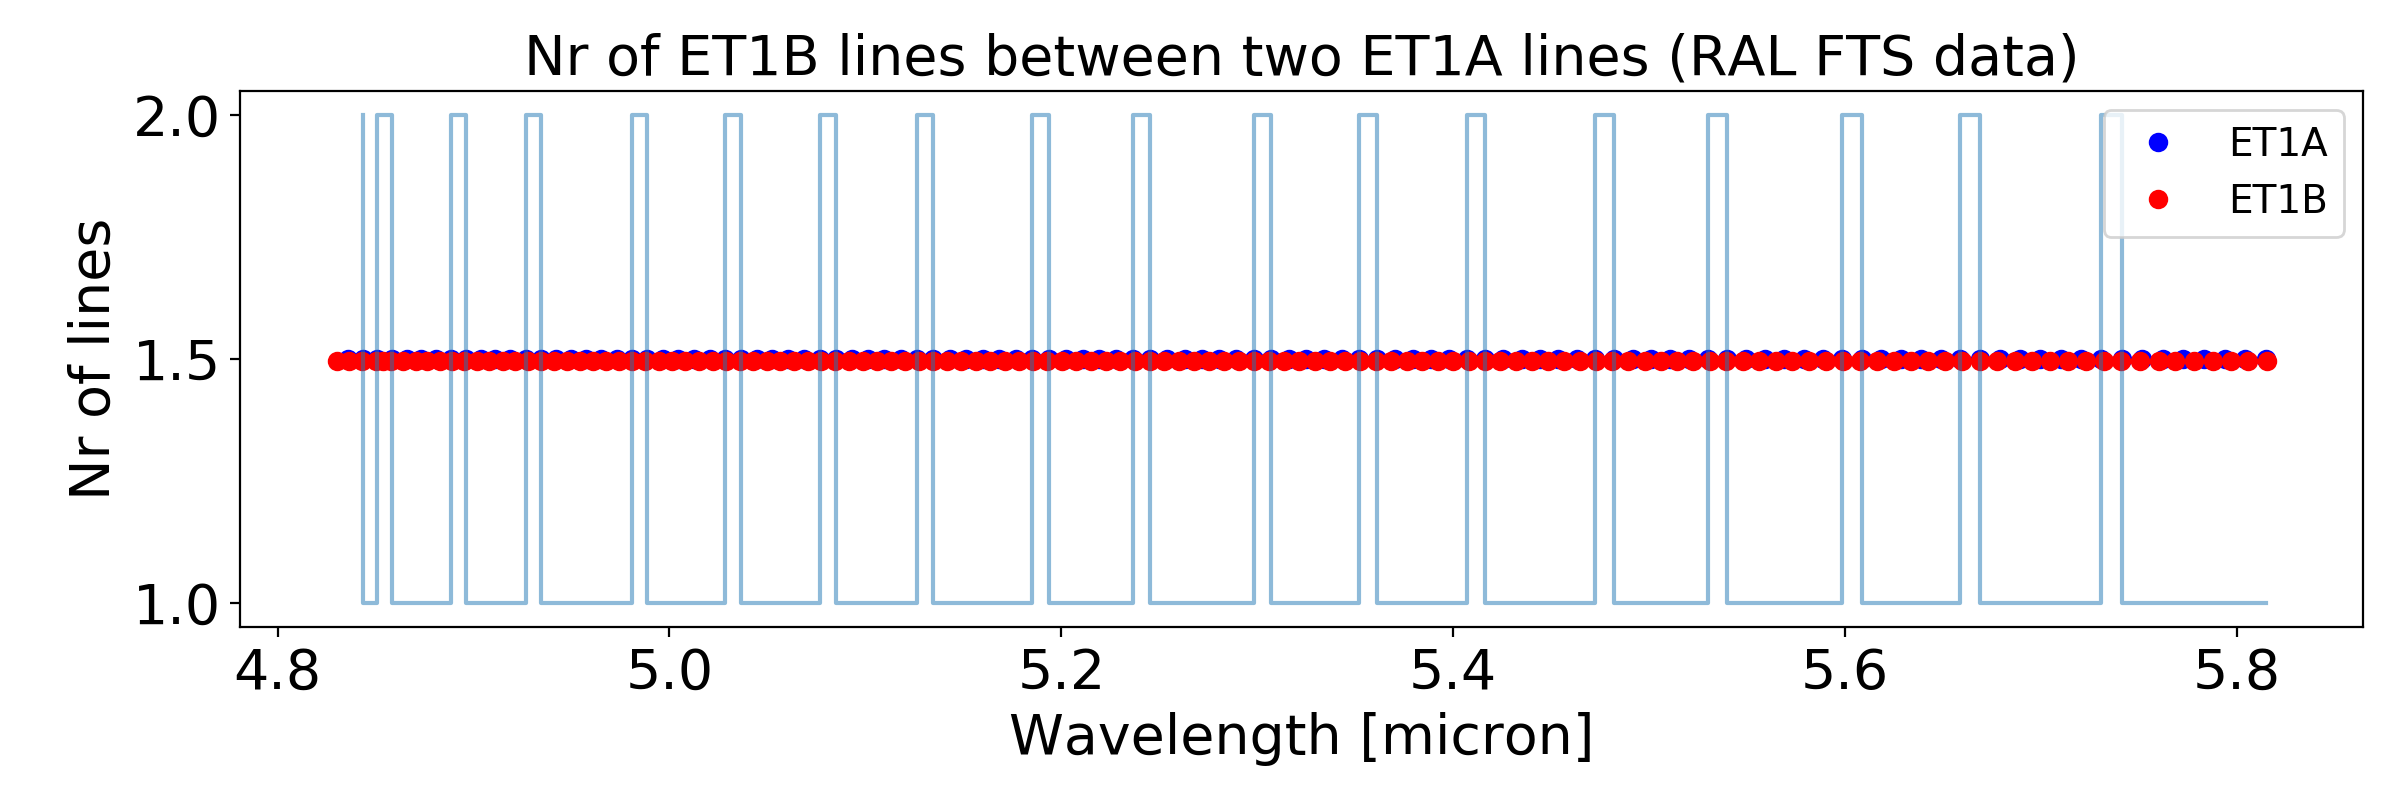

The y-level of the scatter plot (blue and red dots) is arbitrary.


In [15]:
wav_fts_ET1A_peaks = wavs_fts['ET1A'][band][etalon1A_data_fts_peaks]
wav_fts_ET1B_peaks = wavs_fts['ET1B'][band][etalon1B_data_fts_peaks]

fts_ET1B_ET1A_match = np.zeros(len(wav_fts_ET1A_peaks)-1)
for i in range(len(wav_fts_ET1A_peaks)-1):
    fts_ET1B_ET1A_match[i] = len(np.where((wav_fts_ET1B_peaks>wav_fts_ET1A_peaks[i]) & (wav_fts_ET1B_peaks<wav_fts_ET1A_peaks[i+1]) )[0])

plt.figure(figsize=(12,4))
plt.plot(wavs_fts['ET1A'][band][etalon1A_data_fts_peaks],1.5*np.ones(len(etalon1A_data_fts_peaks)),'bo',label='ET1A')
plt.plot(wavs_fts['ET1B'][band][etalon1B_data_fts_peaks],1.495*np.ones(len(etalon1B_data_fts_peaks)),'ro',label='ET1B')
plt.step(wav_fts_ET1A_peaks[1:],fts_ET1B_ET1A_match,alpha=0.5)
plt.xlabel('Wavelength [micron]')
plt.ylabel('Nr of lines')
plt.title('Nr of ET1B lines between two ET1A lines (RAL FTS data)')
plt.legend(loc='upper right')
plt.tight_layout()
print 'The y-level of the scatter plot (blue and red dots) is arbitrary.'

<IPython.core.display.Javascript object>


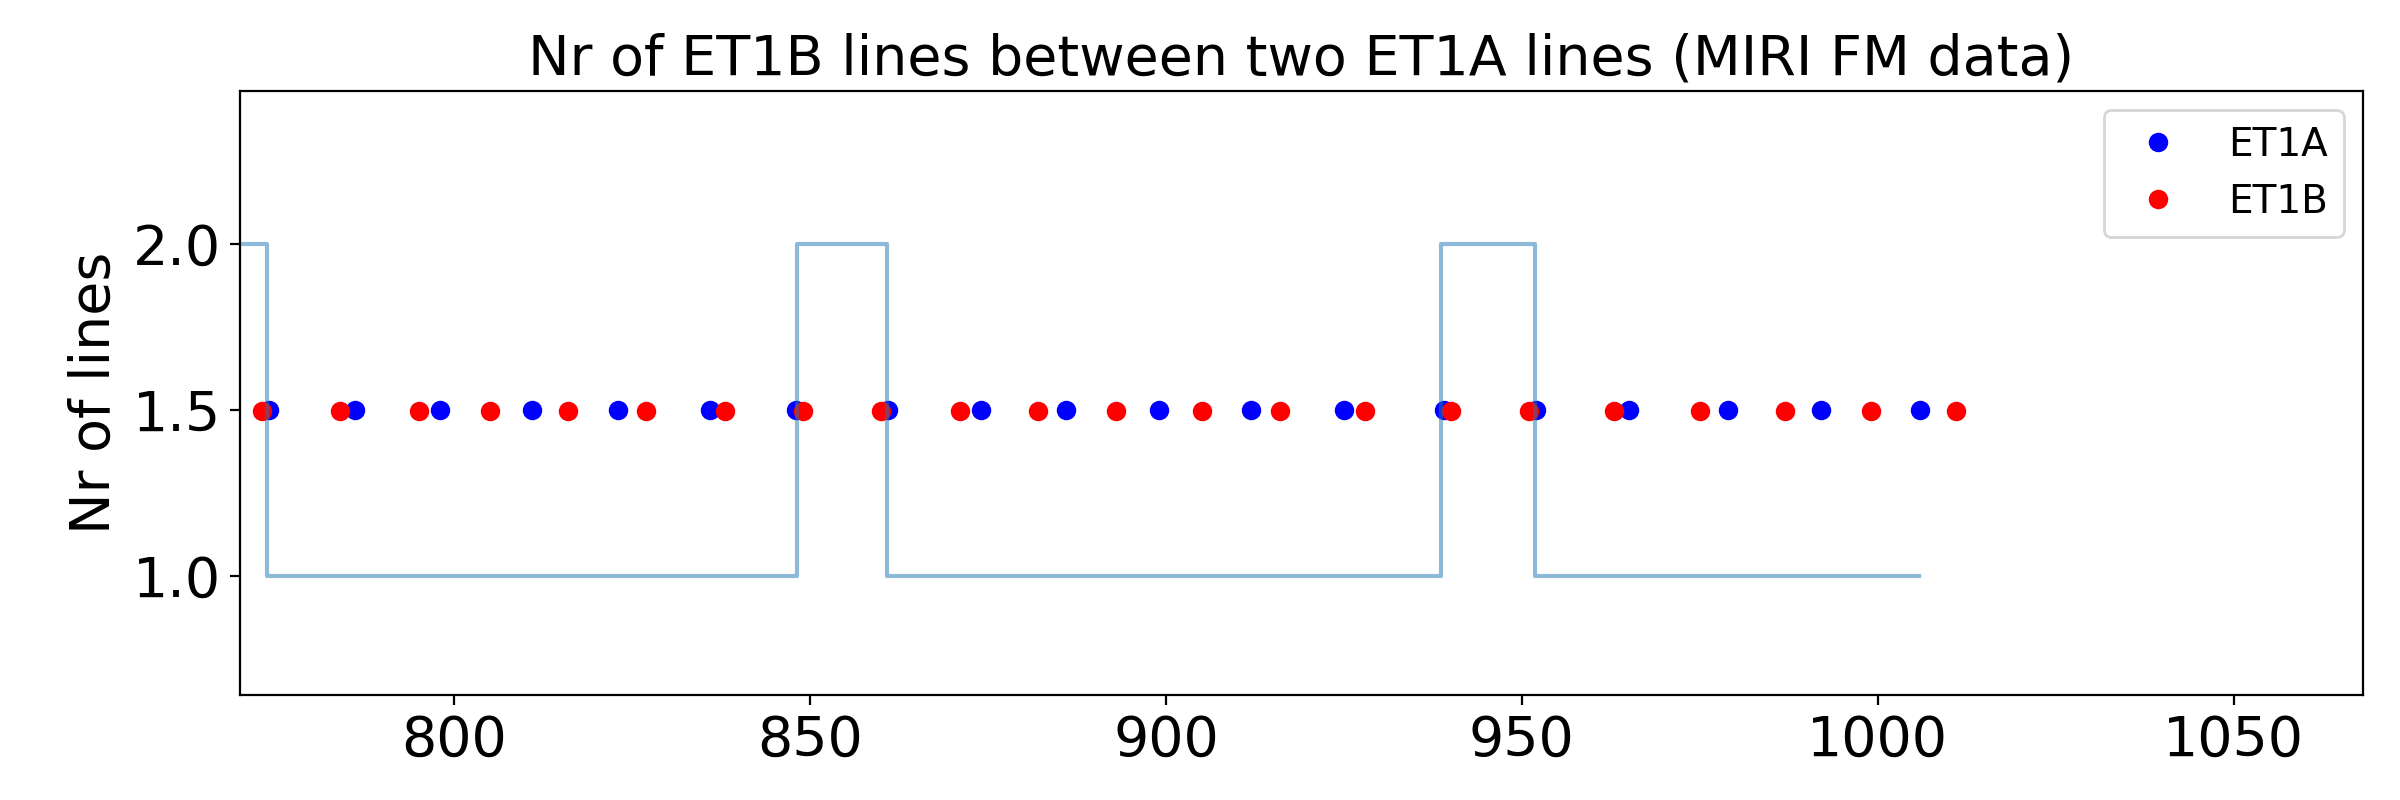

The y-level of the scatter plot (blue and red dots) is arbitrary.


In [16]:
fm_ET1A_peaks = fm_linecenter_ET1A
fm_ET1B_peaks = fm_linecenter_ET1B

fm_ET1B_ET1A_match = np.zeros(len(fm_ET1A_peaks)-1)
for i in range(len(fm_ET1A_peaks)-1):
    fm_ET1B_ET1A_match[i] = len(np.where((fm_ET1B_peaks>fm_ET1A_peaks[i]) & (fm_ET1B_peaks<=fm_ET1A_peaks[i+1]) )[0])
    
plt.figure(figsize=(12,4))
plt.plot(etalon1A_data_fm_peaks,1.5*np.ones(len(etalon1A_data_fm_peaks)),'bo',label='ET1A')
plt.plot(etalon1B_data_fm_peaks,1.495*np.ones(len(etalon1B_data_fm_peaks)),'ro',label='ET1B')
plt.step(fm_ET1A_peaks[1:],fm_ET1B_ET1A_match,alpha=0.5)
plt.ylabel('Nr of lines')
plt.title('Nr of ET1B lines between two ET1A lines (MIRI FM data)')
plt.legend(loc='upper right')
plt.tight_layout()
print 'The y-level of the scatter plot (blue and red dots) is arbitrary.'